In [ ]:
import os
import torch
import pickle
import warnings
import torchaudio
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

# убираем предупреждения
warnings.filterwarnings("ignore", message=".*TorchCodec.*")
warnings.filterwarnings("ignore", message=".*StreamingMediaDecoder.*")

# класс создания общего датасета
class MoodthemeAudioDataset(Dataset):
    def __init__(self, data_dir, labels_dict, mel_spectr_func):
        
        self.data_dir = data_dir
        self.labels_dict = labels_dict
        self.mel_spectr_func = mel_spectr_func

        # множество тегов
        self.moodthemes = set()
        for tags in labels_dict.values():
            self.moodthemes.update(tags)

        # сортриуем и преобразуем теги в индексы
        self.moodthemes = sorted(list(self.moodthemes))
        self.tag_to_idx = {tag: idx for idx, tag in enumerate(self.moodthemes)}
        self.num_classes = len(self.moodthemes)

        # собираем аудиофайлы и теги
        self.audio_files = []
        self.labels = []
        
        for folder_name in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder_name)
            if os.path.isdir(folder_path):
                
                for file_name in os.listdir(folder_path):
                    if self._is_audio_file(file_name):
                        key = os.path.join(folder_name, file_name)
                        if key in labels_dict:
                            full_path = os.path.join(folder_path, file_name)
                            self.audio_files.append(full_path)
                            
                            file_tags = labels_dict[key]
                            multi_hot = self._tags_to_multi_hot(file_tags)
                            self.labels.append(multi_hot)

        self._dummy_mel = self._get_dummy_mel_shape()

    # быстро получает форму мел-спектрограммы
    def _get_dummy_mel_shape(self):
        try:
            dummy_mel = self.mel_spectr_func(self.audio_files[0])
            return dummy_mel.shape
        except:
            return (1, 128, 512) 

    # проверка является ли файл аудиофайлом
    def _is_audio_file(self, filename):
        return filename.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))
    

    # преобразует список тегов в multi-hot вектор
    def _tags_to_multi_hot(self, tags):
        multi_hot = np.zeros(self.num_classes, dtype=np.float32)
        for tag in tags:
            if tag in self.tag_to_idx:
                multi_hot[self.tag_to_idx[tag]] = 1.0
        return multi_hot


    def get_class_names(self):
        return self.moodthemes
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        multi_hot_label = self.labels[idx]
        
        try:
            # вычисляем мел-спектрограмму
            mel_spectrogram = self.mel_spectr_func(audio_path)
            
            # добавляем dimension для канала если нужно
            if len(mel_spectrogram.shape) == 2:
                mel_spectrogram = mel_spectrogram.unsqueeze(0)
            
            # преобразуем метку в тензор
            label_tensor = torch.tensor(multi_hot_label, dtype=torch.float32)
            
            return mel_spectrogram, label_tensor
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            # возвращаем тензоры правильной формы
            return torch.zeros(self._dummy_mel), torch.zeros(self.num_classes)
      
class GPUDatasetWrapper(Dataset):
    def __init__(self, original_dataset, device = 'cuda'):
        self.original_dataset = original_dataset
        self.device = device
        self.gpu_data = []
        self.gpu_labels = []
        
        for i in range(len(original_dataset)):
            data, label = original_dataset[i]
            
            # Переносим на GPU
            data_gpu = data.to(device, non_blocking=True)
            label_gpu = label.to(device, non_blocking=True)
            
            self.gpu_data.append(data_gpu)
            self.gpu_labels.append(label_gpu)
    
    def __len__(self):
        return len(self.gpu_data)
    
    def __getitem__(self, idx):
        # ⚡ Мгновенный доступ - данные уже на GPU
        return self.gpu_data[idx], self.gpu_labels[idx]

def preprocess_audio(audio_path, target_sr = 22050) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    # уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_mels=128,        
        n_fft=1024,       
        hop_length=256,
        f_min=20,
        f_max=11025
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    return mel_spectrogram[0,:,:512]

#------------------------------------------------------------------------------

tags_dict = {}

# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as file:
    tags_dict = pickle.load(file)

# создаём датасет
dataset = MoodthemeAudioDataset(
    data_dir = "../data/train",
    labels_dict = tags_dict,
    mel_spectr_func = preprocess_audio
)

# разбиваем датасет на train и test
dataset_size = len(dataset)
indices = list(range(dataset_size))

train_idx, test_idx = train_test_split(
    indices, 
    test_size = 0.1,
    train_size = 0.4,       
    random_state = 42        # для воспроизводимости
)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# загрузка данных в vram ускорила обучение в сотни раз...
# одна эпоха проходила минут 10-15, теперь 1 секунда
# хотя сама загрузка и занимает 6-7 минут, но потом можно несколько раз запускать тренировку без повторной загрузки данных в память 
# пришлось взять половину датасета (2,59гб), иначе не влазит вместе с моделью
print("Загрузка данных в VRAM...") 
gpu_train_dataset = GPUDatasetWrapper(train_dataset)
gpu_test_dataset = GPUDatasetWrapper(test_dataset)

train_loader = DataLoader(
    gpu_train_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 0,
    pin_memory = False
)

test_loader = DataLoader(
    gpu_test_dataset,
    batch_size = 64,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)

total_vram_used = torch.cuda.memory_allocated('cuda') / 1024**3
print(f"Использовано VRAM: {total_vram_used:.2f} GB")

# тут будут классы моделей
class SimpleFCModel(nn.Module):
    def __init__(self, num_classes: int, input_height: int, input_width: int, hidden_size: int):
        super(SimpleFCModel, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        
        # Вычисляем размер после вытягивания в вектор
        self.flatten_size = input_height * input_width
        
        self.layers = nn.Sequential(
            # Вытягиваем в плоский вектор
            nn.Flatten(),
            
            # Первый скрытый слой
            nn.Linear(self.flatten_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),  # для регуляризации
            
            # Второй скрытый слой (можно добавить больше)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(0.25),
            
            # Выходной слой
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

Загрузка данных в VRAM...
Использовано VRAM: 2.59 GB


In [7]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    
    pbar = tqdm(loader, desc='Training')
    
    for data, targets in pbar:        
        optimizer.zero_grad()                           # Обнуляем градиенты
        outputs = model(data)                           # Прямой проход
        loss = criterion(outputs, targets)              # Вычисляем loss
        loss.backward()                                 # 
        optimizer.step()                                # Обратный проход
        
        with torch.no_grad():                           # 
            probs = torch.sigmoid(outputs)              #
            predictions = (probs > 0.5).float()         # Сохраняем предсказания и цели для метрик
                                                        #
            all_targets.append(targets.cpu())           #
            all_predictions.append(predictions.cpu())   #
        
        running_loss += loss.item()                     # Обновляем статистику
        
        # Обновляем прогресс-бар
        current_loss = running_loss / len(loader)       
        pbar.set_postfix({'Loss': f'{current_loss:.4f}'})
    
    # Вычисляем метрики
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)
    
    # Accuracy
    accuracy = (all_predictions == all_targets).float().mean().item()
    
    # F1-score (macro)
    f1 = f1_score(all_targets.numpy(), all_predictions.numpy(), average='macro', zero_division=0)
    
    epoch_loss = running_loss / len(loader)
    
    return {
        'loss': epoch_loss,
        'accuracy': accuracy,
        'f1': f1
    }

def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Evaluation')
    
    with torch.no_grad():
        for data, targets in pbar:
            data = data.to(device)                      #
            targets = targets.to(device)                # Перемещаем данные на устройство
            
            outputs = model(data)                       # Прямой проход
            
            loss = criterion(outputs, targets)          # Вычисляем loss
            
            probs = torch.sigmoid(outputs)              # 
            predictions = (probs > 0.5).float()         # Получаем вероятности и предсказания

            all_targets.append(targets.cpu())           # 
            all_predictions.append(predictions.cpu())   #
            all_probs.append(probs.cpu())               # Сохраняем для метрик
            
            running_loss += loss.item()                 # Обновляем статистику
            
            # Обновляем прогресс-бар
            current_loss = running_loss / len(loader)
            pbar.set_postfix({'Loss': f'{current_loss:.4f}'})
    
    # Объединяем все батчи
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)
    all_probs = torch.cat(all_probs)
    
    # Вычисляем метрики
    accuracy = (all_predictions == all_targets).float().mean().item()
    f1 = f1_score(all_targets.numpy(), all_predictions.numpy(), average='macro', zero_division=0)
    epoch_loss = running_loss / len(loader)
    
    return {
        'loss': epoch_loss,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probs
    }

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, save_dir='../data/models'):
    # Создаем директорию для сохранения
    os.makedirs(save_dir, exist_ok=True)
    
    # Инициализируем лучшие метрики
    best_f1 = 0.0
    best_epoch = 0
    
    # История обучения
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_f1': [],
        'val_loss': [], 'val_accuracy': [], 'val_f1': []
    }
    
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        print('-' * 50)
        
        # Обучение
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Валидация
        val_metrics = evaluate_epoch(model, val_loader, criterion, device)
        
        # Сохраняем историю
        history['train_loss'].append(train_metrics['loss'])
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        
        # Выводим метрики
        print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, F1: {train_metrics["f1"]:.4f}')
        print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, F1: {val_metrics["f1"]:.4f}')
        
        # Сохраняем лучшую модель
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_epoch = epoch
            
            # Сохраняем модель
            best_model_path = os.path.join(save_dir, 'FCmodel_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_f1,
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['accuracy']
            }, best_model_path)
            print(f'✓ New best model saved! F1: {best_f1:.4f}')
        
        # Сохраняем бэкап каждые 5 эпох
        if epoch % 5 == 0:
            backup_path = os.path.join(save_dir, f'FCmodel_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_f1,
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['accuracy']
            }, backup_path)
            print(f'✓ Backup saved: {backup_path}')
    
    print(f'\nTraining completed!')
    print(f'Best model: epoch {best_epoch}, F1: {best_f1:.4f}')
    
    return history, best_f1

def load_model(model, checkpoint_path, optimizer=None, device='cuda', verbose=True):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Загружаем веса модели
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Загружаем оптимизатор если нужно
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # Переносим состояние оптимизатора на правильное устройство
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    
    if verbose:
        print(f'Model loaded from {checkpoint_path}')
        print(f'Epoch: {checkpoint["epoch"]}')
        val_f1 = checkpoint.get('val_f1', 'N/A')
        print(f'Val F1: {val_f1}')
    
    return model

def plot_history(history, figsize=(15, 10)):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Создаем subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Training History', fontsize=16, fontweight='bold')
    
    # 1. График Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. График Accuracy
    axes[0, 1].plot(epochs, history['train_accuracy'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # 3. График F1-score
    axes[1, 0].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    axes[1, 0].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    axes[1, 0].set_title('F1-Score (Macro)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0, 1)
    
    # 4. Сводный график всех метрик (валидация) - ИСПРАВЛЕННАЯ ЧАСТЬ
    axes[1, 1].plot(epochs, history['val_accuracy'], 'g-', label='Val Accuracy', linewidth=2)
    axes[1, 1].plot(epochs, history['val_f1'], 'orange', label='Val F1', linewidth=2)
    
    # ИСПРАВЛЕНИЕ: преобразуем в numpy array перед делением
    val_loss = np.array(history['val_loss'])
    if max(val_loss) > 0:  # Проверяем чтобы не делить на 0
        val_loss_norm = val_loss / max(val_loss)
    else:
        val_loss_norm = val_loss
    
    axes[1, 1].plot(epochs, val_loss_norm, 'r-', label='Val Loss (norm)', linewidth=2)
    axes[1, 1].set_title('Validation Metrics Summary')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим лучшие значения
    best_val_acc = max(history['val_accuracy'])
    best_val_f1 = max(history['val_f1'])
    best_epoch_acc = history['val_accuracy'].index(best_val_acc) + 1
    best_epoch_f1 = history['val_f1'].index(best_val_f1) + 1
    
    print("Training Results Summary:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f} (epoch {best_epoch_acc})")
    print(f"Best Validation F1-Score: {best_val_f1:.4f} (epoch {best_epoch_f1})")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {history['train_f1'][-1]:.4f}")

Используется устройство: cuda
Количество параметров модели: 16817979

Epoch 1/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 779.13it/s, Loss=0.1502]


Train - Loss: 0.3152, Acc: 0.8979, F1: 0.0410
Val   - Loss: 0.1502, Acc: 0.9696, F1: 0.0011
✓ New best model saved! F1: 0.0011

Epoch 2/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 759.18it/s, Loss=0.1436]


Train - Loss: 0.1881, Acc: 0.9581, F1: 0.0217
Val   - Loss: 0.1436, Acc: 0.9697, F1: 0.0000

Epoch 3/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 778.74it/s, Loss=0.1398]


Train - Loss: 0.1687, Acc: 0.9648, F1: 0.0120
Val   - Loss: 0.1398, Acc: 0.9698, F1: 0.0002

Epoch 4/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 674.45it/s, Loss=0.1397]


Train - Loss: 0.1597, Acc: 0.9670, F1: 0.0103
Val   - Loss: 0.1397, Acc: 0.9700, F1: 0.0000

Epoch 5/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 789.64it/s, Loss=0.1419]


Train - Loss: 0.1532, Acc: 0.9682, F1: 0.0103
Val   - Loss: 0.1419, Acc: 0.9700, F1: 0.0002
✓ Backup saved: ../data/models/FCmodel_5.pth

Epoch 6/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 812.26it/s, Loss=0.1369]


Train - Loss: 0.1525, Acc: 0.9686, F1: 0.0109
Val   - Loss: 0.1369, Acc: 0.9700, F1: 0.0011

Epoch 7/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 768.32it/s, Loss=0.1365]


Train - Loss: 0.1466, Acc: 0.9690, F1: 0.0099
Val   - Loss: 0.1365, Acc: 0.9700, F1: 0.0002

Epoch 8/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 784.85it/s, Loss=0.1391]


Train - Loss: 0.1434, Acc: 0.9693, F1: 0.0119
Val   - Loss: 0.1391, Acc: 0.9700, F1: 0.0002

Epoch 9/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 712.74it/s, Loss=0.1351]


Train - Loss: 0.1437, Acc: 0.9693, F1: 0.0141
Val   - Loss: 0.1351, Acc: 0.9700, F1: 0.0002

Epoch 10/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 746.42it/s, Loss=0.1396]


Train - Loss: 0.1401, Acc: 0.9695, F1: 0.0143
Val   - Loss: 0.1396, Acc: 0.9699, F1: 0.0002
✓ Backup saved: ../data/models/FCmodel_10.pth

Epoch 11/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 776.20it/s, Loss=0.1350]


Train - Loss: 0.1386, Acc: 0.9695, F1: 0.0121
Val   - Loss: 0.1350, Acc: 0.9700, F1: 0.0002

Epoch 12/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 734.10it/s, Loss=0.1349]


Train - Loss: 0.1374, Acc: 0.9696, F1: 0.0150
Val   - Loss: 0.1349, Acc: 0.9700, F1: 0.0002

Epoch 13/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 762.75it/s, Loss=0.1360]


Train - Loss: 0.1360, Acc: 0.9697, F1: 0.0186
Val   - Loss: 0.1360, Acc: 0.9700, F1: 0.0000

Epoch 14/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 768.70it/s, Loss=0.1352]


Train - Loss: 0.1341, Acc: 0.9696, F1: 0.0165
Val   - Loss: 0.1352, Acc: 0.9697, F1: 0.0006

Epoch 15/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 759.83it/s, Loss=0.1345]


Train - Loss: 0.1327, Acc: 0.9698, F1: 0.0209
Val   - Loss: 0.1345, Acc: 0.9699, F1: 0.0000
✓ Backup saved: ../data/models/FCmodel_15.pth

Epoch 16/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 763.38it/s, Loss=0.1346]


Train - Loss: 0.1313, Acc: 0.9699, F1: 0.0229
Val   - Loss: 0.1346, Acc: 0.9699, F1: 0.0002

Epoch 17/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 764.17it/s, Loss=0.1327]


Train - Loss: 0.1312, Acc: 0.9700, F1: 0.0258
Val   - Loss: 0.1327, Acc: 0.9699, F1: 0.0015
✓ New best model saved! F1: 0.0015

Epoch 18/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 735.51it/s, Loss=0.1351]


Train - Loss: 0.1289, Acc: 0.9699, F1: 0.0264
Val   - Loss: 0.1351, Acc: 0.9699, F1: 0.0008

Epoch 19/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 742.53it/s, Loss=0.1340]


Train - Loss: 0.1284, Acc: 0.9699, F1: 0.0240
Val   - Loss: 0.1340, Acc: 0.9699, F1: 0.0006

Epoch 20/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 764.49it/s, Loss=0.1328]


Train - Loss: 0.1274, Acc: 0.9700, F1: 0.0301
Val   - Loss: 0.1328, Acc: 0.9698, F1: 0.0018
✓ New best model saved! F1: 0.0018
✓ Backup saved: ../data/models/FCmodel_20.pth

Epoch 21/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 683.31it/s, Loss=0.1352]


Train - Loss: 0.1255, Acc: 0.9700, F1: 0.0342
Val   - Loss: 0.1352, Acc: 0.9699, F1: 0.0016

Epoch 22/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 728.76it/s, Loss=0.1341]


Train - Loss: 0.1253, Acc: 0.9701, F1: 0.0363
Val   - Loss: 0.1341, Acc: 0.9699, F1: 0.0012

Epoch 23/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 631.82it/s, Loss=0.1327]


Train - Loss: 0.1235, Acc: 0.9700, F1: 0.0380
Val   - Loss: 0.1327, Acc: 0.9699, F1: 0.0016

Epoch 24/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 763.34it/s, Loss=0.1335]


Train - Loss: 0.1226, Acc: 0.9701, F1: 0.0427
Val   - Loss: 0.1335, Acc: 0.9699, F1: 0.0018
✓ New best model saved! F1: 0.0018

Epoch 25/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 804.76it/s, Loss=0.1347]


Train - Loss: 0.1214, Acc: 0.9703, F1: 0.0478
Val   - Loss: 0.1347, Acc: 0.9698, F1: 0.0033
✓ New best model saved! F1: 0.0033
✓ Backup saved: ../data/models/FCmodel_25.pth

Epoch 26/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 762.55it/s, Loss=0.1335]


Train - Loss: 0.1205, Acc: 0.9703, F1: 0.0496
Val   - Loss: 0.1335, Acc: 0.9698, F1: 0.0045
✓ New best model saved! F1: 0.0045

Epoch 27/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 776.51it/s, Loss=0.1341]


Train - Loss: 0.1183, Acc: 0.9703, F1: 0.0547
Val   - Loss: 0.1341, Acc: 0.9697, F1: 0.0034

Epoch 28/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 768.12it/s, Loss=0.1337]


Train - Loss: 0.1183, Acc: 0.9704, F1: 0.0554
Val   - Loss: 0.1337, Acc: 0.9699, F1: 0.0019

Epoch 29/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 785.14it/s, Loss=0.1336]


Train - Loss: 0.1185, Acc: 0.9704, F1: 0.0587
Val   - Loss: 0.1336, Acc: 0.9697, F1: 0.0031

Epoch 30/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 795.01it/s, Loss=0.1348]


Train - Loss: 0.1173, Acc: 0.9705, F1: 0.0637
Val   - Loss: 0.1348, Acc: 0.9697, F1: 0.0046
✓ New best model saved! F1: 0.0046
✓ Backup saved: ../data/models/FCmodel_30.pth

Epoch 31/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 807.21it/s, Loss=0.1343]


Train - Loss: 0.1151, Acc: 0.9706, F1: 0.0625
Val   - Loss: 0.1343, Acc: 0.9696, F1: 0.0052
✓ New best model saved! F1: 0.0052

Epoch 32/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 803.14it/s, Loss=0.1335]


Train - Loss: 0.1136, Acc: 0.9707, F1: 0.0719
Val   - Loss: 0.1335, Acc: 0.9696, F1: 0.0038

Epoch 33/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 657.80it/s, Loss=0.1335]


Train - Loss: 0.1137, Acc: 0.9706, F1: 0.0693
Val   - Loss: 0.1335, Acc: 0.9696, F1: 0.0068
✓ New best model saved! F1: 0.0068

Epoch 34/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 818.84it/s, Loss=0.1330]


Train - Loss: 0.1126, Acc: 0.9706, F1: 0.0757
Val   - Loss: 0.1330, Acc: 0.9697, F1: 0.0036

Epoch 35/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 771.58it/s, Loss=0.1364]


Train - Loss: 0.1106, Acc: 0.9709, F1: 0.0797
Val   - Loss: 0.1364, Acc: 0.9696, F1: 0.0060
✓ Backup saved: ../data/models/FCmodel_35.pth

Epoch 36/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 802.41it/s, Loss=0.1348]


Train - Loss: 0.1108, Acc: 0.9708, F1: 0.0835
Val   - Loss: 0.1348, Acc: 0.9697, F1: 0.0031

Epoch 37/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 695.97it/s, Loss=0.1343]


Train - Loss: 0.1092, Acc: 0.9710, F1: 0.0940
Val   - Loss: 0.1343, Acc: 0.9695, F1: 0.0039

Epoch 38/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 711.97it/s, Loss=0.1353]


Train - Loss: 0.1076, Acc: 0.9710, F1: 0.0947
Val   - Loss: 0.1353, Acc: 0.9695, F1: 0.0061

Epoch 39/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 815.87it/s, Loss=0.1361]


Train - Loss: 0.1064, Acc: 0.9712, F1: 0.1053
Val   - Loss: 0.1361, Acc: 0.9694, F1: 0.0076
✓ New best model saved! F1: 0.0076

Epoch 40/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 739.17it/s, Loss=0.1385]


Train - Loss: 0.1067, Acc: 0.9713, F1: 0.1097
Val   - Loss: 0.1385, Acc: 0.9693, F1: 0.0055
✓ Backup saved: ../data/models/FCmodel_40.pth

Epoch 41/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 791.65it/s, Loss=0.1363]


Train - Loss: 0.1062, Acc: 0.9711, F1: 0.1056
Val   - Loss: 0.1363, Acc: 0.9694, F1: 0.0065

Epoch 42/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 741.95it/s, Loss=0.1389]


Train - Loss: 0.1048, Acc: 0.9714, F1: 0.1207
Val   - Loss: 0.1389, Acc: 0.9693, F1: 0.0073

Epoch 43/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 754.68it/s, Loss=0.1370]


Train - Loss: 0.1032, Acc: 0.9715, F1: 0.1283
Val   - Loss: 0.1370, Acc: 0.9690, F1: 0.0088
✓ New best model saved! F1: 0.0088

Epoch 44/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 751.63it/s, Loss=0.1382]


Train - Loss: 0.1028, Acc: 0.9717, F1: 0.1319
Val   - Loss: 0.1382, Acc: 0.9693, F1: 0.0088
✓ New best model saved! F1: 0.0088

Epoch 45/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 850.61it/s, Loss=0.1376]


Train - Loss: 0.1021, Acc: 0.9716, F1: 0.1321
Val   - Loss: 0.1376, Acc: 0.9693, F1: 0.0064
✓ Backup saved: ../data/models/FCmodel_45.pth

Epoch 46/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 800.07it/s, Loss=0.1383]


Train - Loss: 0.1003, Acc: 0.9718, F1: 0.1472
Val   - Loss: 0.1383, Acc: 0.9694, F1: 0.0076

Epoch 47/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 802.74it/s, Loss=0.1394]


Train - Loss: 0.1015, Acc: 0.9718, F1: 0.1471
Val   - Loss: 0.1394, Acc: 0.9692, F1: 0.0086

Epoch 48/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 792.96it/s, Loss=0.1383]


Train - Loss: 0.0997, Acc: 0.9719, F1: 0.1573
Val   - Loss: 0.1383, Acc: 0.9694, F1: 0.0071

Epoch 49/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 833.94it/s, Loss=0.1400]


Train - Loss: 0.0972, Acc: 0.9722, F1: 0.1684
Val   - Loss: 0.1400, Acc: 0.9692, F1: 0.0111
✓ New best model saved! F1: 0.0111

Epoch 50/50
--------------------------------------------------


Evaluation: 100%|██████████| 29/29 [00:00<00:00, 741.12it/s, Loss=0.1403]


Train - Loss: 0.0980, Acc: 0.9721, F1: 0.1603
Val   - Loss: 0.1403, Acc: 0.9692, F1: 0.0102
✓ Backup saved: ../data/models/FCmodel_50.pth

Training completed!
Best model: epoch 49, F1: 0.0111


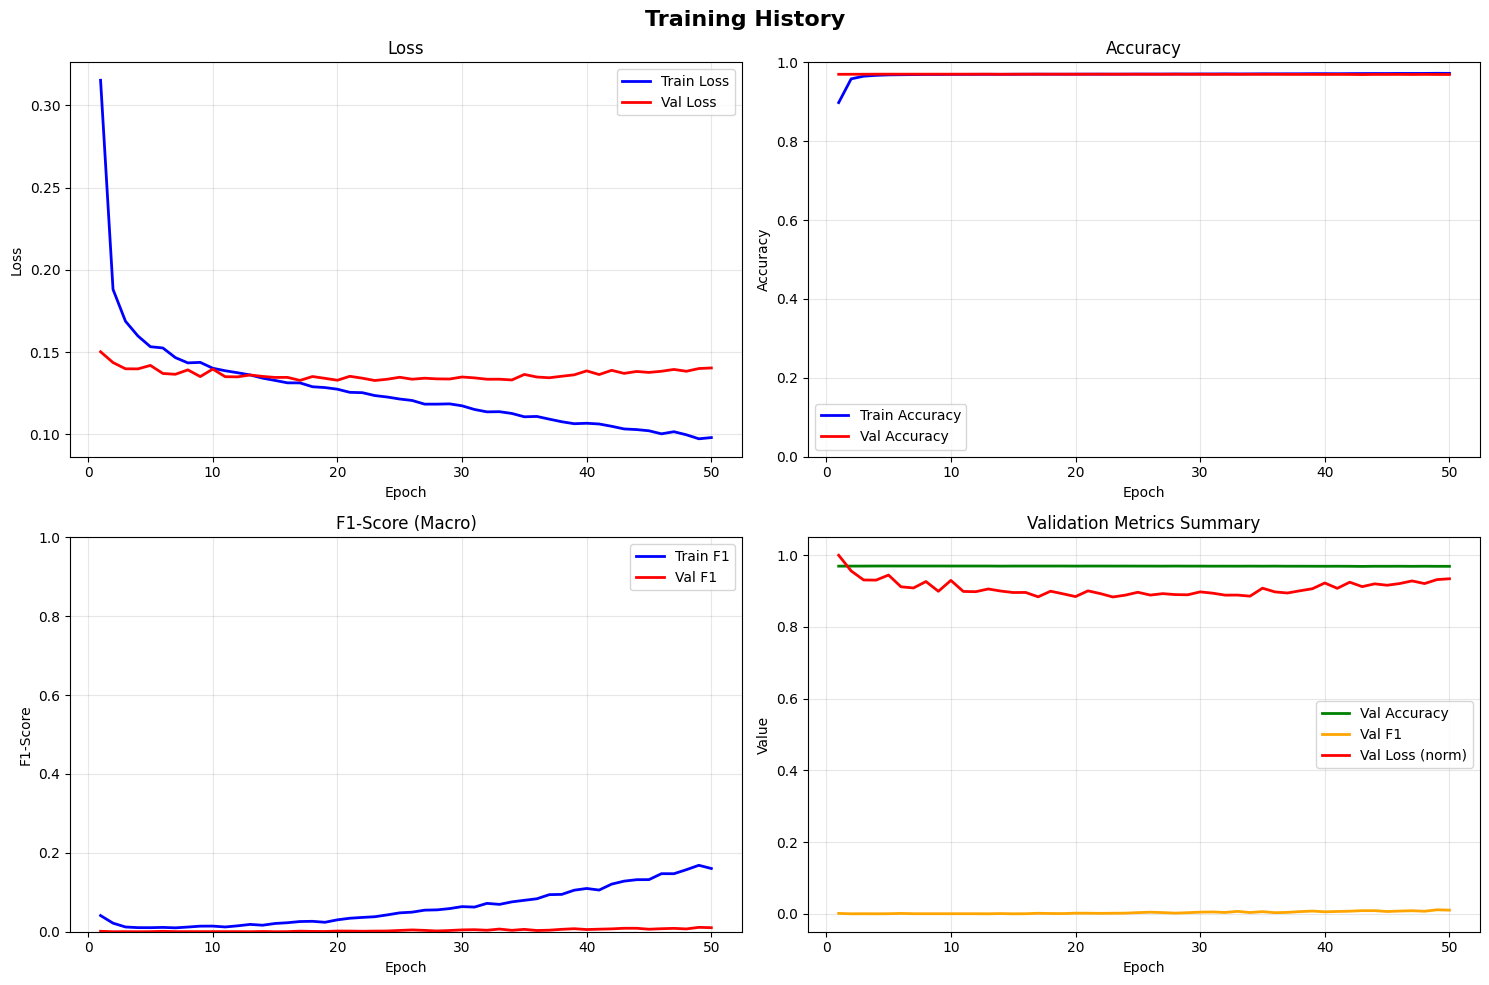

Training Results Summary:
Best Validation Accuracy: 0.9700 (epoch 5)
Best Validation F1-Score: 0.0111 (epoch 49)
Final Validation Loss: 0.1403
Final Train Accuracy: 0.9721
Final Train F1: 0.1603


In [16]:
# Инициализация модели
model = SimpleFCModel(
    num_classes=len(dataset.get_class_names()),
    input_height=128,
    input_width=512,
    hidden_size=256
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Используется устройство: {device}")

print(f"Количество параметров модели: {sum(p.numel() for p in model.parameters())}")

# Загрузка модели
# model = load_model(
#     model=model,
#     checkpoint_path="../data/models/FCmodel_5.pth",
#     optimizer=optimizer
# )

# Переносим модел на устройство
model.to(device)

# Запуск обучения
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=50,
    save_dir='../data/models'
)

# вывод графиков
plot_history(history)

In [21]:
def quick_predict(model, audio_path, preprocess_function, class_names, device='cuda', treshold = 0.5):
    # Убедимся, что модель на правильном устройстве
    model.to(device)
    model.eval()
    
    try:
        # Препроцессинг
        mel_spec = preprocess_function(audio_path)
        
        # Добавляем batch dimension и перемещаем на устройство
        if len(mel_spec.shape) == 3:  # [channels, height, width]
            input_tensor = mel_spec.unsqueeze(0)  # [1, channels, height, width]
        else:
            input_tensor = mel_spec.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width]
        
        input_tensor = input_tensor.to(device)
        
        # Предсказание
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Результаты
        print(f"\n Prediction for: {os.path.basename(audio_path)}")
        
        active_tags = []
        for i, (class_name, prob) in enumerate(zip(class_names, probs)):
            if prob > treshold:
                print(f"  -- {class_name}: {prob:.3f}")
                active_tags.append(class_name)
        
        if not active_tags:
            print(f" No tags predicted above 0.5 threshold")
            
        return probs, active_tags
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

best_model = SimpleFCModel(
    input_height=128,        
    input_width=512,          
    hidden_size=256,  
    num_classes=len(dataset.get_class_names()),             
)

load_model(best_model, '../data/models/FCmodel_best.pth')
best_model.to(device)
best_model.eval()

test_audio_path = "../data/train/00/7400.mp3"

quick_predict(
    model=model,
    audio_path=test_audio_path,
    preprocess_function=preprocess_audio,
    class_names=dataset.get_class_names(),
    device=device,
    treshold = 0.1
)

Model loaded from ../data/models/FCmodel_best.pth
Epoch: 49
Val F1: 0.011121491407396525

 Prediction for: 7400.mp3
  -- dark: 0.124
  -- drama: 0.107
  -- film: 0.137
  -- sad: 0.114


(array([2.81417137e-03, 2.34183180e-03, 1.02701550e-03, 1.86840575e-02,
        4.98032710e-03, 2.16210796e-03, 8.32586258e-04, 4.30440326e-04,
        9.57917597e-04, 1.39419746e-04, 1.88094564e-03, 1.48814361e-04,
        1.23803295e-01, 2.04439653e-04, 5.19552361e-03, 1.06578991e-01,
        1.51930156e-03, 7.55550014e-03, 8.38819966e-02, 7.53089366e-03,
        4.59576063e-02, 2.60053475e-05, 1.37173146e-01, 3.90673144e-04,
        2.00938419e-04, 2.53528729e-03, 7.83886135e-05, 2.92311888e-03,
        2.88420211e-04, 9.09089649e-05, 6.83494553e-04, 1.64148910e-03,
        1.29820993e-02, 3.13233621e-02, 1.49967894e-02, 2.03259774e-02,
        4.62711410e-04, 5.45352744e-03, 4.60217678e-04, 2.35788450e-02,
        5.41124260e-03, 5.15964581e-04, 1.64741214e-04, 3.46870534e-03,
        2.19799317e-02, 5.47859585e-04, 1.02813551e-02, 1.14168003e-01,
        3.30595103e-05, 2.93046050e-02, 3.28093045e-03, 2.75542997e-02,
        1.55542640e-03, 2.22323761e-05, 2.80598433e-05, 2.022281